# Anomaly Detection with Auto-Encoders

MNIST 데이터셋을 이용하여 AutoEncoder의 이상치 탐지에 사용하였습니다. 

2를 학습시키고 2와 유사한 형태인 2와 7을 비교하여 7이면 이상치 score가 높게, 2면 이상치 score가 낮게 나오도록 설정하였습니다.

학습이 완료된 AutoEncoder에 새로운 이미지를 넣어 MSE를 사용하여 결과를 비교하였습니다.

In [39]:
import os
import numpy as np
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.datasets import MNIST
import pylab
import matplotlib.pyplot as plt

In [54]:
class Mnist_dataset(Dataset):
    def __init__(self, datasets ,labels:list):
        self.dataset = [datasets[i][0] for i in range(len(datasets))
                        if datasets[i][1] in labels ]
        self.labels = labels
        self.len_oneclass = int(len(self.dataset)/10)

    def __len__(self):
        return int(len(self.dataset))

    def __getitem__(self, index):
        img = self.dataset[index]
        return img,[]

In [55]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64))

        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        out = self.decoder(x)
        return out

In [74]:
batch_size = 64
num_epochs = 50
learning_rate = 1e-4
cuda = True
model = Autoencoder()
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

if cuda:
    model.cuda()

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))  # [0,1] => [-1,1]
])

DataLoader는 batch_size만큼 데이터를 가져오는 generator를 생성하게 됩니다. batch size의 경우 64로 설정하였습니다.

In [75]:
train_dataset = MNIST('./data', download=True,train=True, transform=img_transform)
train = Mnist_dataset(train_dataset,[1])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
losses = np.zeros(num_epochs)

재구성된 출력 이미지와 입력 이미지 사이에서 loss를 계산합니다.

In [76]:
for epoch in range(num_epochs):
    i = 0
    for img,_ in train_loader:
        
        x = img.view(img.size(0), -1)

        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)

        out = model(x)

        loss = mse_loss(out, x)
        losses[epoch] = losses[epoch] * (i / (i + 1.)) + loss * (1. / (i + 1.))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1

    plt.figure()
    pylab.xlim(0, num_epochs)
    plt.plot(range(0, num_epochs), losses, label='loss')
    plt.legend()
    plt.close()

    print(f'epoch [{epoch+1}/{num_epochs}], loss: {loss}')

epoch [1/50], loss: 0.12051767855882645
epoch [2/50], loss: 0.1095074787735939
epoch [3/50], loss: 0.05384824052453041
epoch [4/50], loss: 0.05625475198030472
epoch [5/50], loss: 0.04207344725728035
epoch [6/50], loss: 0.03176954761147499
epoch [7/50], loss: 0.04685652256011963
epoch [8/50], loss: 0.03962147608399391
epoch [9/50], loss: 0.03850395604968071
epoch [10/50], loss: 0.03063344955444336
epoch [11/50], loss: 0.02579493634402752
epoch [12/50], loss: 0.03464539349079132
epoch [13/50], loss: 0.02314537949860096
epoch [14/50], loss: 0.026834998279809952
epoch [15/50], loss: 0.0177212692797184
epoch [16/50], loss: 0.025890512391924858
epoch [17/50], loss: 0.022555269300937653
epoch [18/50], loss: 0.021749768406152725
epoch [19/50], loss: 0.03207845613360405
epoch [20/50], loss: 0.018921174108982086
epoch [21/50], loss: 0.028352195397019386
epoch [22/50], loss: 0.020067187026143074
epoch [23/50], loss: 0.024517469108104706
epoch [24/50], loss: 0.024845508858561516
epoch [25/50], los

In [77]:
test_dataset = MNIST('./data', train=False,download=True, transform=img_transform)
test = Mnist_dataset(test_dataset,[1,9])
test_loader = DataLoader(test, batch_size=len(test_dataset), shuffle=True)

for img,_ in test_loader:
    x = img.view(img.size(0), -1)

    if cuda:
        x = Variable(x).cuda()
    else:
        x = Variable(x)

    out = model(x)
    x = x.cpu().detach().numpy()
    out = out.cpu().detach().numpy()
    x = x/2 + 0.5
    out = out/2 + 0.5


## 시각화
테스트 데이터셋의 이미지와 AutoEncoder의 출력 이미지를 하였습니다.

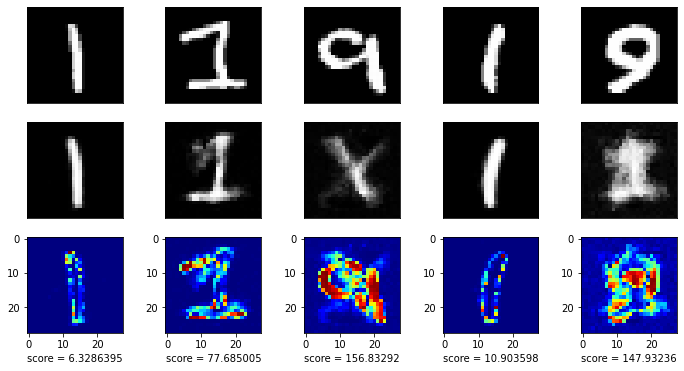

In [78]:
plt.figure(figsize=(12, 6))
for i in range(5):
    # test dataset
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # AutoEncoder output
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(out[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 두 이미지의 차이 계산
    diff_img = np.abs(x[i] - out[i])
    diff = np.sum(diff_img)
    ax = plt.subplot(3, 5, i + 1 + 5 * 2)
    plt.imshow(diff_img.reshape(28, 28),cmap="jet")
    
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_xlabel('score = ' + str(diff))

plt.show()
plt.close()

## 실험결과
실험결과 같은 숫자이며 형태가 비슷할수록 이상치 score가 낮은 것을 확인할 수 있으며, 형태가 완전히 다른 경우 이상치 score가 확연히 높은 것을 확인할 수 있었습니다. 실험결과를 통해서도 알 수 있듯이 AutoEncoder는 입력의 작은 변화에 모델이 민감하게 반응하는 단점이 있습니다. 

실험은 하지 않았지만 Denoising AutoEncoder, Convolutiona AutoEncoder를 사용할 수 있습니다. CAE(Convolution AutoEncoder)에서는 padding size를 조절가능하여 dimension을 조절이 가능하다. 또한 CAE의 경우 다른 실험을 참고 하였을 때 AE보다 normal과 anormal의 Reconstruction Error는 CAE가 우수하다는 것도 참고하면 좋을 것 같습니다.

[Reference](https://chioni.github.io/posts/ae/)

# One-class SVM

One-class SVM은 데이터를 feature 공간에 매핑하고 원점과의 거리를 최대화할 수 있는 초평면을 찾는 것이 목적입니다. 기존의 SVM과 유사한 목적식을 갖고 있지만 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from sklearn.svm import OneClassSVM

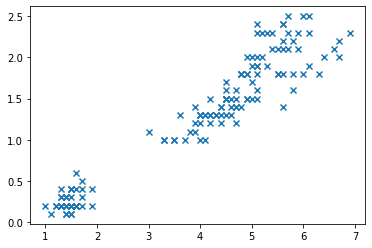

In [27]:
from sklearn import datasets

iris = datasets.load_iris()

X = iris["data"][:, [2, 3]]  # petal length, petal width
y = iris["target"]

plt.scatter(X[:,0],X[:,1],marker="x")

In [28]:
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
gamma_list = [0.001, 0.01, 0.1, 1]

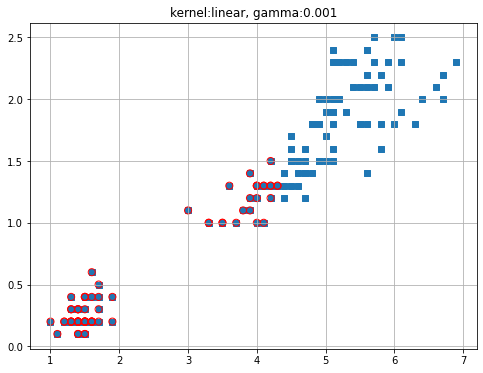

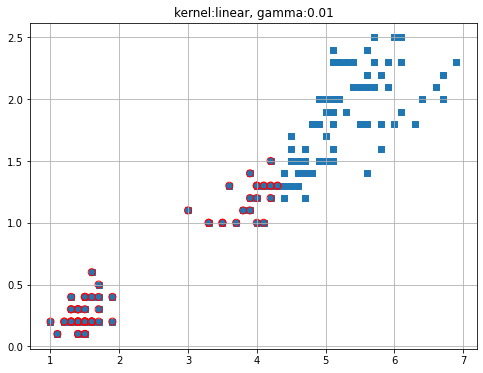

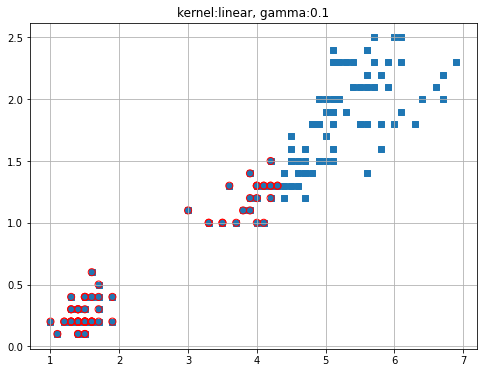

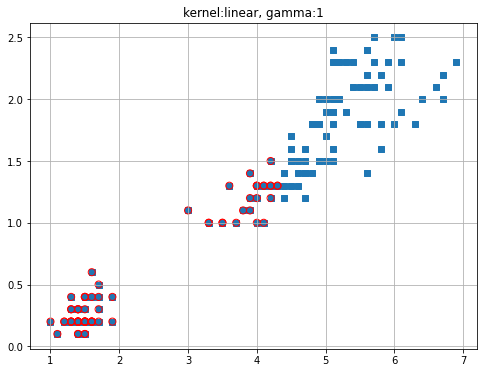

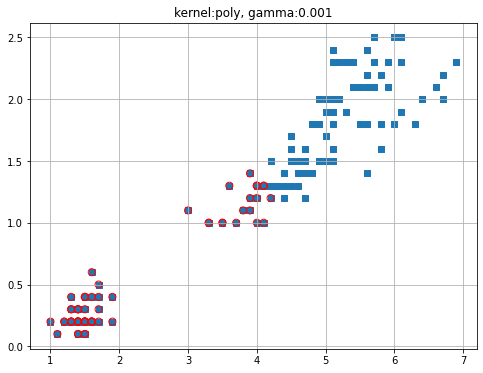

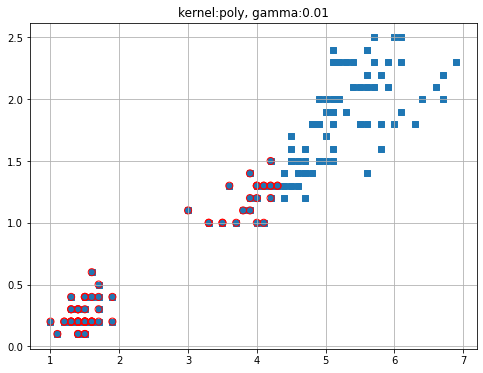

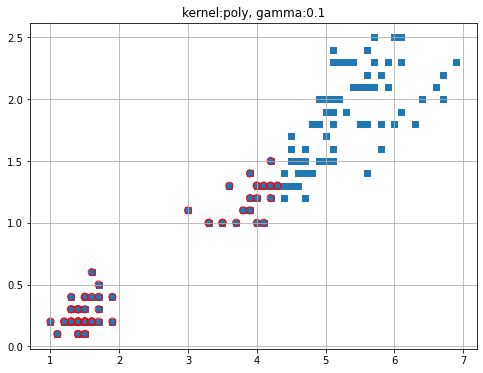

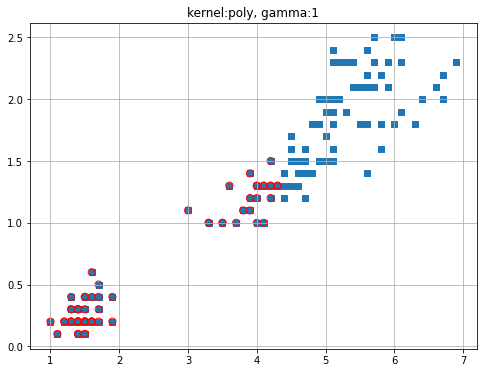

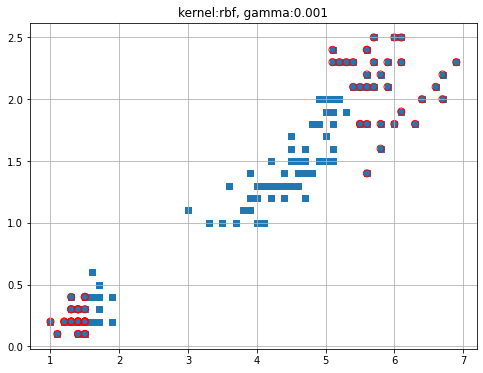

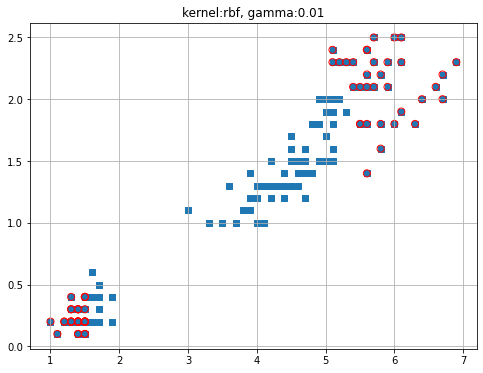

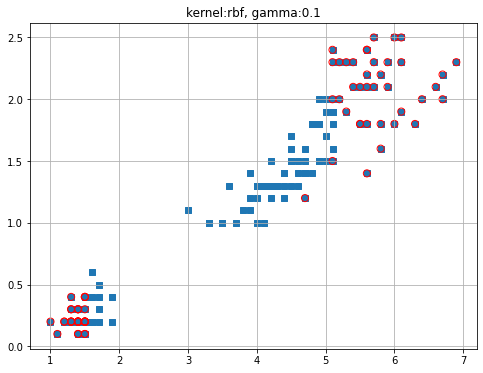

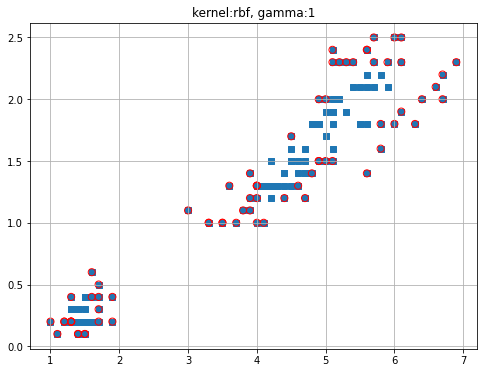

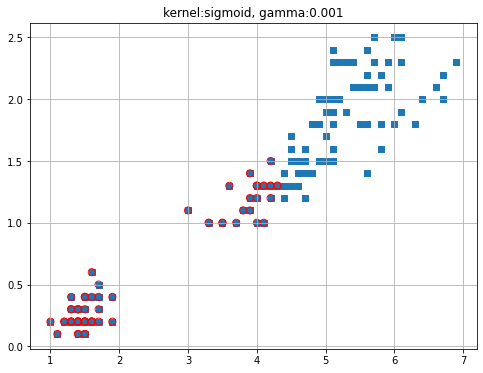

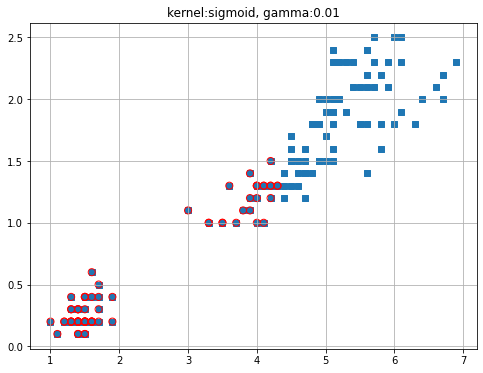

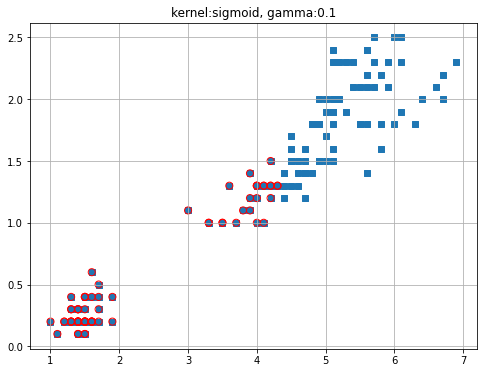

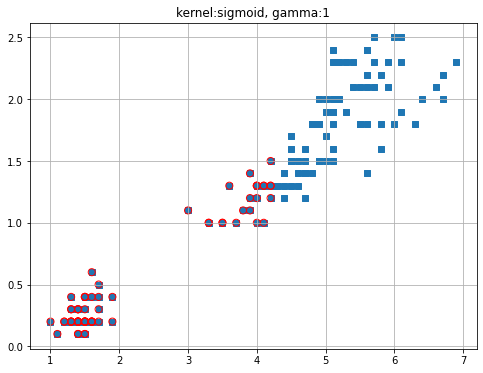

In [83]:
for kernel in kernel_list:
    for gamma in gamma_list:
        one_svm = OneClassSVM(kernel=kernel, gamma=gamma).fit(X)
        one_svm_label = one_svm.fit_predict(X)
        index = np.where(one_svm_label == -1)
        plt.figure(figsize=(8,6))
        plt.grid(True)
        plt.title(f'kernel:{kernel}, gamma:{gamma}')
        plt.scatter(X[:,0],X[:,1],marker="s")
        plt.scatter(X[index,0],X[index,1],marker="o",facecolor="none",edgecolor="r",s=50)

## 실험결과
rbf kernel의 경우 gamma값이 커짐에 따라 정상 데이터의 범주가 작아지면서 이상치 데이터의 비중이 많아지는 것을 확인할 수 있었습니다. rbf를 제외한 나머지 kernel은 gamma값에는 크게 영향을 받지 않는 것으로 확인할 수 있었습니다. rbf 외 다른 kernel 별 차이를 확인하기 위해서는 다른 데이터셋을 사용해보는게 좋을 것 같습니다.

# Isolation Forests

Isolation forest는 하나의 이상치를 고립시키는 Tree를 생성시키는 것이 목적인 알고리즘입니다. 이상치는 개체수가 적어, 정상 범주 데이터와는 특정 속성 값이 많이 다를 가능성이 높습니다. 이상치를 고립시킬 때까지 몇 번이나 분기했는지에 대한 정보로 이상치 점수를 부여하게 됩니다. 

In [24]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize

iris = datasets.load_iris()
scaler = StandardScaler()

X = iris["data"][:, [2, 3]]  # petal length, petal width
y = iris["target"]

데이터는 iris 데이터를 사용하여 비교하였습니다. 

n_estimators는 10, 50, 100을 비교하였으며, 이상치 탐지 기준은 0.01, 0.05, 0.1 3가지 경우를 비교하였습니다.

In [35]:
n_estimators_list = [10, 50, 100]
contamination_list = [0.01, 0.05, 0.1]

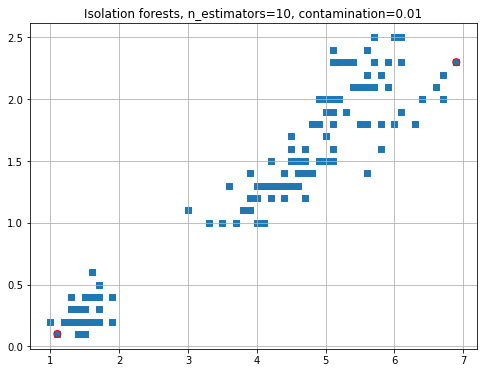

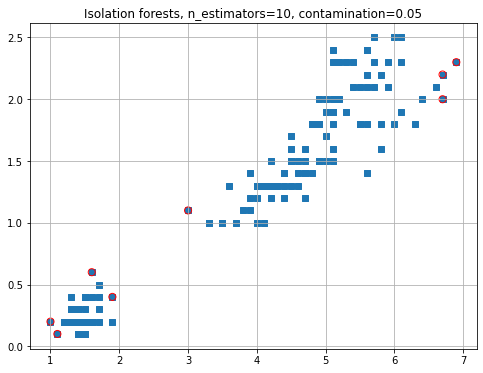

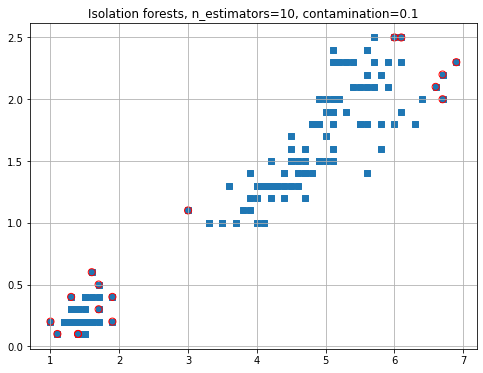

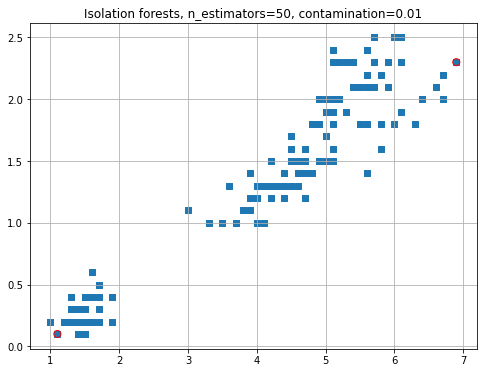

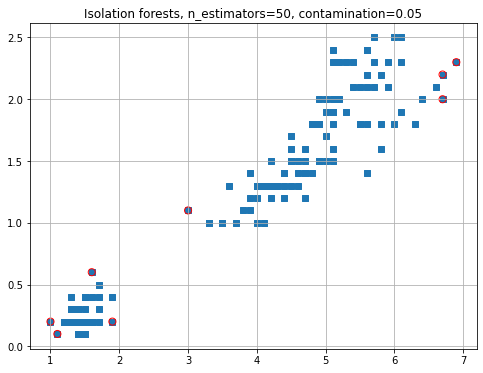

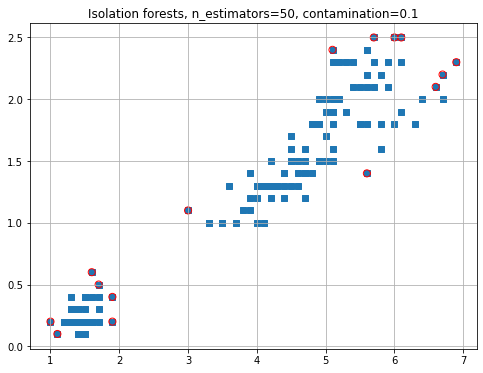

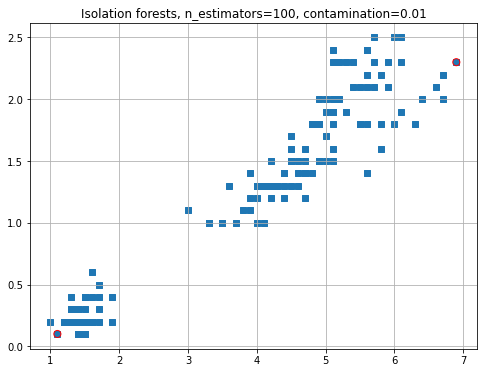

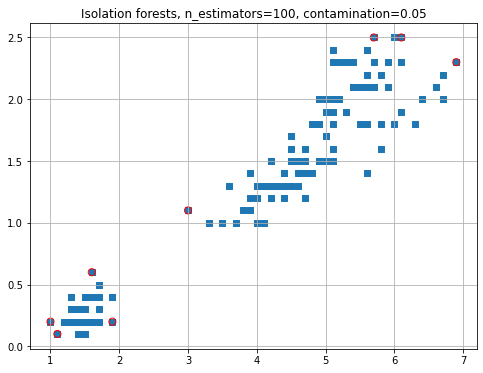

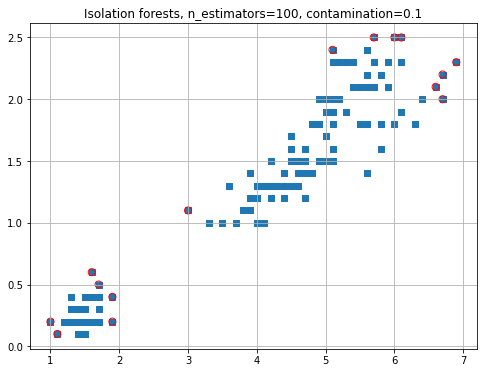

In [36]:
for n_estimators in n_estimators_list:
    for contamination in contamination_list:
        Iso = IsolationForest(n_estimators= n_estimators, warm_start=True, contamination=contamination).fit(X)
        scores_iso = Iso.score_samples(X)
        thresh_iso = np.quantile(scores_iso, contamination)
        index_iso = np.where(scores_iso <= thresh_iso)
        plt.figure(figsize = (8,6))
        plt.grid(True)
        plt.title(f'Isolation forests, n_estimators={n_estimators}, contamination={contamination}')
        plt.scatter(X[:,0],X[:,1],marker="s")
        plt.scatter(X[index_iso,0],X[index_iso,1],marker="o",facecolor="none",edgecolor="r",s=50)
        
        

## 실험결과
당연한 결과이지만 contatmination이 높을수록, n_estimators가 높을수록 더 많은 이상치를 탐지하는 것을 확인할 수 있었습니다. Isolation Forest은 Density based Anomaly Detection 보다는 이상치 탐지가 정확하게 이루어지는 것을 확인할 수 있었습니다. 
고차원 데이터에 대해서 작동한다는 장점이 있는 Isolatin forest를 확인하기 위해서는 보다 고차원데이터에 적용해보는게 좋을 것 같습니다.